In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import tqdm.notebook as tq

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df_data = pd.read_excel("intents.xlsx").fillna(0)

In [3]:
df_data

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info,none
0,"thôi shop oi, hủy đon hàng của tao đi",0,0,0,0,0,0,0,1,0,0
1,"Hủy đơn hàng đi, tớ đổi ý rồi!",0,0,0,0,0,0,0,1,0,0
2,confirm lại giup em đơn hàng mới voi ạ,0,0,0,0,0,1,0,0,0,0
3,để cố gắng cái vỏ nướng giòn nhé,0,0,0,0,0,0,0,0,0,1
4,có cách nào biết được đơn hàng của mình đang ở...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10211,"không muon đặt nua, huy gium",0,0,0,0,0,0,0,1,0,0
10212,"đặt hỏi, hủy đơn giúp",0,0,0,0,0,0,0,1,0,0
10213,"không muốn pizza nữa, hủy đơn giúp",0,0,0,0,0,0,0,1,0,0
10214,"bây giờ t thấy ko muốn nữa, hủy đi",0,0,0,0,0,0,0,1,0,0


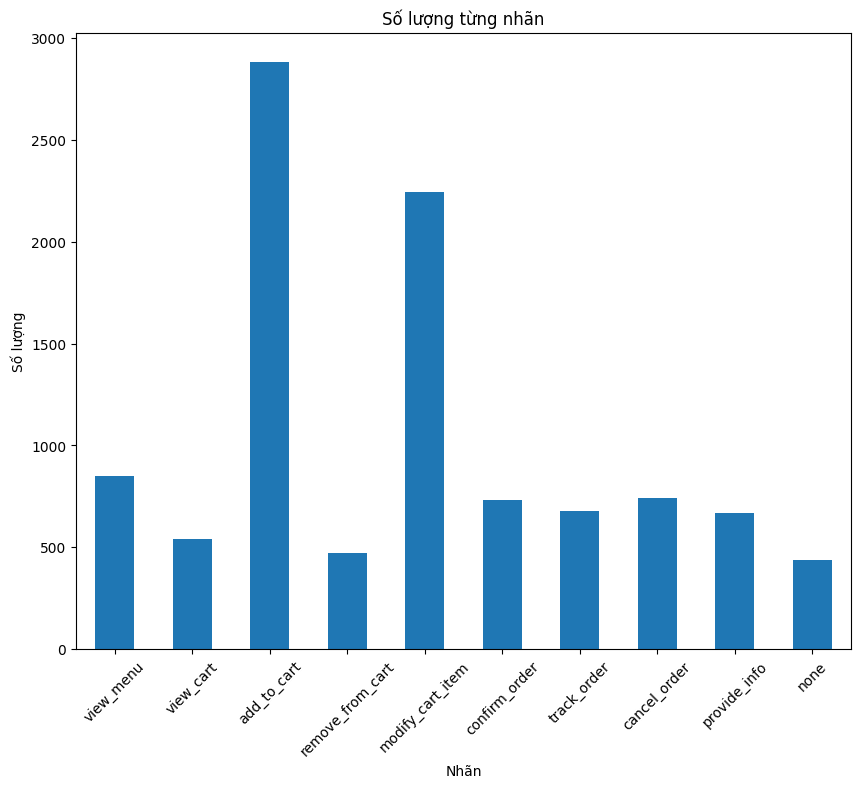

In [4]:
label_counts = df_data.drop(columns=['text']).sum()

plt.figure(figsize=(10, 8))
label_counts.plot(kind='bar')
plt.title('Số lượng từng nhãn')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

In [5]:
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.2, shuffle=True)
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.5, shuffle=True)

In [6]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (8172, 11), Test: (1022, 11), Valid: (1022, 11)


In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [8]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5

In [9]:
class MultiLabelDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [10]:
target_list = list(df_data.columns)
target_list

['text',
 'view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'none']

In [11]:
target_list = target_list[1:]

In [12]:
train_dataset = MultiLabelDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = MultiLabelDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = MultiLabelDataset(df_test, tokenizer, MAX_LEN, target_list)

In [13]:
train_data_loader = DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [14]:
class PhoBertForMultiLabelClassification(nn.Module):
    def __init__(self):
        super(PhoBertForMultiLabelClassification, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = torch.nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, 10)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.phobert(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [15]:
model = PhoBertForMultiLabelClassification()
model.to(device)

PhoBertForMultiLabelClassification(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = AdamW(model.parameters(), lr=1e-5)

In [17]:
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [18]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)

In [19]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "pizza_intent.bin")
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/511 [00:00<?, ?it/s]

train_loss=0.2842, val_loss=0.1601 train_acc=0.9163, val_acc=0.9521
Epoch 2/10


  0%|          | 0/511 [00:00<?, ?it/s]

train_loss=0.1279, val_loss=0.0888 train_acc=0.9671, val_acc=0.9840
Epoch 3/10


  0%|          | 0/511 [00:00<?, ?it/s]

train_loss=0.0753, val_loss=0.0644 train_acc=0.9866, val_acc=0.9852
Epoch 4/10


  0%|          | 0/511 [00:00<?, ?it/s]

train_loss=0.0523, val_loss=0.0504 train_acc=0.9903, val_acc=0.9885
Epoch 5/10


  0%|          | 0/511 [00:00<?, ?it/s]

train_loss=0.0394, val_loss=0.0494 train_acc=0.9925, val_acc=0.9872
Epoch 6/10


  0%|          | 0/511 [00:00<?, ?it/s]

KeyboardInterrupt: 

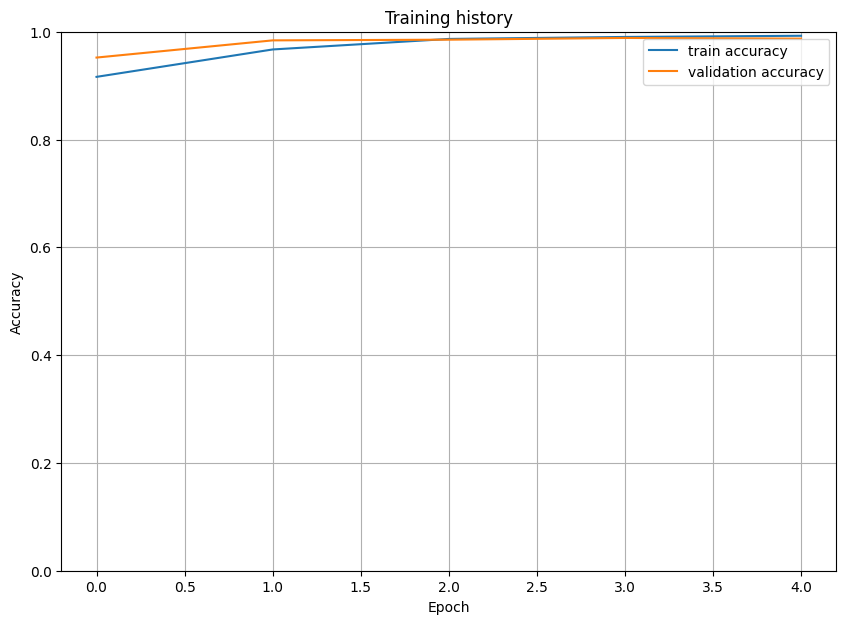

In [20]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

In [22]:
model = PhoBertForMultiLabelClassification()
model.load_state_dict(torch.load("pizza_intent.bin"))
model = model.to(device)
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [23]:
test_acc

0.9880626223091976

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
def get_predictions(model, data_loader):
    model = model.eval()

    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).detach().cpu()
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return titles, predictions, prediction_probs, target_values
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)
print(classification_report(target_values, predictions, target_names=target_list))

                  precision    recall  f1-score   support

       view_menu       0.97      0.99      0.98        79
       view_cart       0.98      0.90      0.94        51
     add_to_cart       0.94      0.97      0.96       297
remove_from_cart       0.98      0.94      0.96        48
modify_cart_item       0.95      0.97      0.96       219
   confirm_order       0.93      0.91      0.92        69
     track_order       0.97      0.89      0.93        71
    cancel_order       0.95      0.94      0.94        64
    provide_info       0.91      0.99      0.94        78
            none       0.88      0.47      0.61        47

       micro avg       0.95      0.93      0.94      1023
       macro avg       0.95      0.90      0.91      1023
    weighted avg       0.95      0.93      0.94      1023
     samples avg       0.93      0.93      0.93      1023



C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


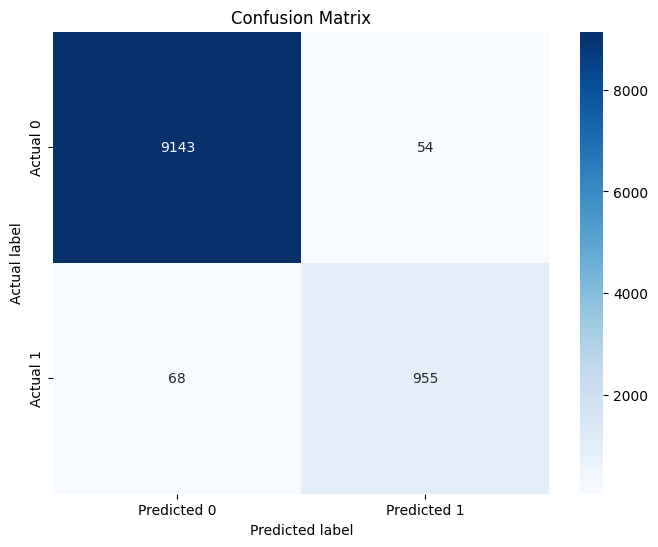

In [48]:
y_pred = predictions.numpy()
y_true = target_values.numpy()

y_pred = y_pred.flatten()
y_true = y_true.flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

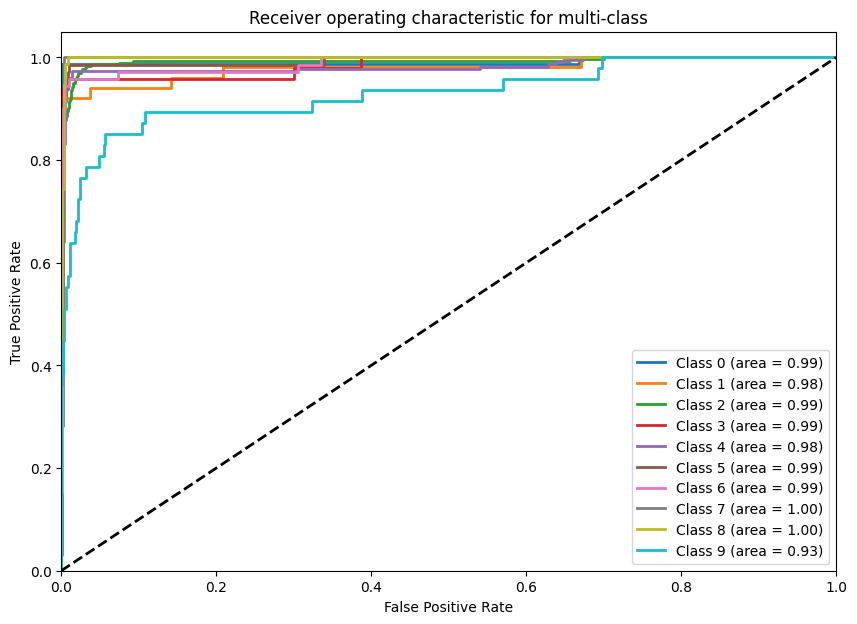

In [58]:
def plot_multiclass_roc_curve(target_values, prediction_probs, n_classes):
    if not isinstance(target_values, np.ndarray):
        target_values = target_values.numpy()
    if not isinstance(prediction_probs, np.ndarray):
        prediction_probs = prediction_probs.numpy()
    
    lw = 2

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(target_values[:, i], prediction_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
                 label='Class {0} (area = {1:0.2f})'.format(i, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class')
    plt.legend(loc="lower right")
    plt.show()

n_classes = target_values.shape[1]

plot_multiclass_roc_curve(target_values, prediction_probs, n_classes)


In [31]:
def predict_text(raw_text):
  encoded_text = tokenizer.encode_plus(
      raw_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=True,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
  )
  input_ids = encoded_text['input_ids'].to(device)
  attention_mask = encoded_text['attention_mask'].to(device)
  token_type_ids = encoded_text['token_type_ids'].to(device)
  output = model(input_ids, attention_mask, token_type_ids)
  output = torch.sigmoid(output).detach().cpu()
  output = output.flatten().round().numpy()
  print(output)
  for idx, p in enumerate(output):
    if p==1:
      return target_list[idx]

In [46]:
predict_text("bao trang thai đơn hàng cho mink")

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


'track_order'